In [1]:
import os
import nibabel as nib
from nilearn import image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from nilearn import datasets, image, plotting

In [2]:
processed_folder = "/media/moemen/Stuff/project/data/processed"

# Load fMRI Data

In [3]:
data_location = "/media/moemen/Stuff/project/data/ds003643-download/derivatives"

In [4]:
EN_subject_list = [folder for folder in os.listdir(data_location) if "EN" in folder]

In [7]:
current_subject = EN_subject_list[0]

In [8]:
sample_subject_path = os.path.join(data_location, current_subject, 'func')

In [9]:
subject_processed_folder = os.path.join(processed_folder, current_subject)
if not os.path.exists(subject_processed_folder):
    os.mkdir(subject_processed_folder)

In [10]:
fmri_file_list = os.listdir(sample_subject_path)

In [11]:
len(fmri_file_list)

9

## Smooth and Normalize the data (Run once)

In [207]:
smoothing = 5

In [1041]:
normalized_folder = os.path.join(subject_processed_folder, "normalized")
if not os.path.exists(normalized_folder):
    os.mkdir(normalized_folder)

In [1042]:
affine = nib.load(os.path.join(sample_subject_path, fmri_file_list[0])).affine

In [210]:
# Uncomment these lines to perform normalization in addition to smoothing

def normalize_fmri(fmri, smoothing=0):
    fmri = image.smooth_img(fmri, smoothing)
    fmri = fmri.get_fdata()
#    mean_along_temporal_axis = np.mean(fmri, axis=-1)
#    std_along_temporal_axis = np.std(fmri, axis=-1)
#    mean = np.transpose(np.array([[mean_along_temporal_axis] * fmri.shape[-1]][0]), (1,2,3,0))
#    std = np.transpose(np.array([[std_along_temporal_axis] * fmri.shape[-1]][0]), (1,2,3,0))
#    return np.nan_to_num((fmri - mean) / std, nan=0)
    return fmri

In [211]:
for fmri_file in fmri_file_list:
    normalized_location = os.path.join(normalized_folder, fmri_file[:fmri_file.find("space")]+".npy")
    fmri = nib.load(os.path.join(sample_subject_path, fmri_file))
    normalized_fmri = normalize_fmri(fmri, smoothing)
    np.save(normalized_location, normalized_fmri)

## Select ROI

In [12]:
ROIs = [{"name": "left_amygdala", "coord": (-30, -4, -22)}, 
        {"name": "right_amygdala", "coord": (30, -4, -22)}, 
        {"name": "right_insula", "coord": (42, -2, 4)},
        {"name": "left_insula", "coord": (-42, -2, 4)},
        {"name": "periaqueductal", "coord": (0, -30, -10)},
        {"name": "left_ventral_striatum", "coord": (-10, 10, -6)},
        {"name": "right_ventral_striatum", "coord": (10, 10, -6)},
        {"name": "left_putamen", "coord": (-24, 0, 4)},
        {"name": "right_putamen", "coord": (24, 0, 4)},
        {"name": "anterior_cingulate", "coord": (0, 30, 18)},
        {"name": "ventromedial_prefronal", "coord": (0, 42, -12)},
        {"name": "ventral_tegmental", "coord": (4, -18, -14)},
        {"name": "V6", "coord": (9, -82, 36)},
        {"name": "V1", "coord": (-4, -88, -2)}, 
        {"name": "noise", "coord": (-65, -100, -55)}] # bottom left corner

In [13]:
ROI = ROIs[0]

In [14]:
rois_folder = os.path.join(subject_processed_folder, "ROIs")
if not os.path.exists(rois_folder):
    os.mkdir(rois_folder)

In [15]:
roi_folder = os.path.join(rois_folder, ROI["name"])
if not os.path.exists(roi_folder):
    os.mkdir(roi_folder)

In [245]:
def reverse_transform(coord, affine):
    # Transforms coordinates from MNI space to regular space
    x2, y2, z2 = coord
    reverse_affine = np.linalg.inv(affine)
    x1, y1, z1 = image.coord_transform(x2, y2, z2, reverse_affine)
    return (round(x1), round(y1), round(z1))

In [246]:
def get_roi_cube(roi_mni_coord, affine, fmri, cube_size):
    x, y, z = roi_mni_coord
    a = 0
    b = 0
    c = 0
    cube = np.zeros(shape=(cube_size,cube_size,cube_size,fmri.shape[-1]))
    for i in range(-int(cube_size/2), math.ceil(cube_size/2)):
        b = 0
        for j in range(-int(cube_size/2), math.ceil(cube_size/2)):
            c = 0
            for k in range(-int(cube_size/2), math.ceil(cube_size/2)):
                x2, y2, z2 = reverse_transform((x+i, y+j, z+k), affine)
                cube[a, b, c, :] = fmri[x2, y2, z2, :]
                c+=1
            b+=1
        a+=1

    return cube

In [247]:
cube_size = 5
for fmri_file in os.listdir(normalized_folder):
    normalized_fmri = np.load(os.path.join(normalized_folder, fmri_file))
    cube = get_roi_cube(ROI["coord"], affine, normalized_fmri, cube_size)
    print(cube.shape)
    output_file = os.path.join(rResults: LOSO FR-ENoi_folder, fmri_file)
    assert(not np.any(cube == 0))
    np.save(output_file, cube)

(5, 5, 5, 282)
(5, 5, 5, 298)
(5, 5, 5, 340)
(5, 5, 5, 303)
(5, 5, 5, 265)
(5, 5, 5, 343)
(5, 5, 5, 325)
(5, 5, 5, 292)
(5, 5, 5, 368)


In [ ]:
cube

# Preprocess Labels

In [8]:
def voting_filter(df, label_columns, window_size):
    result = pd.DataFrame(index=df.index, columns=label_columns)

    for i in range(0, len(df), window_size):
        window = df.iloc[i:i+window_size]

        if not window.empty:
            # Count occurrences of each label in the window
            label_counts = window[label_columns].sum()

            # Find the most common label
            if max(label_counts) == 0:
                result.loc[window.index] = 0
                continue
            most_common_label = label_counts.idxmax()

            # Assign the most common label to all rows in the window
            result.loc[window.index] = 0
            result.loc[window.index, most_common_label] = 1

    return result

In [11]:
sentiment_df = pd.read_csv("/home/moemen/CMPUT624/labels/new_EN_labels_with_timing.csv")

In [12]:
sentiment_df.shape

(1499, 8)

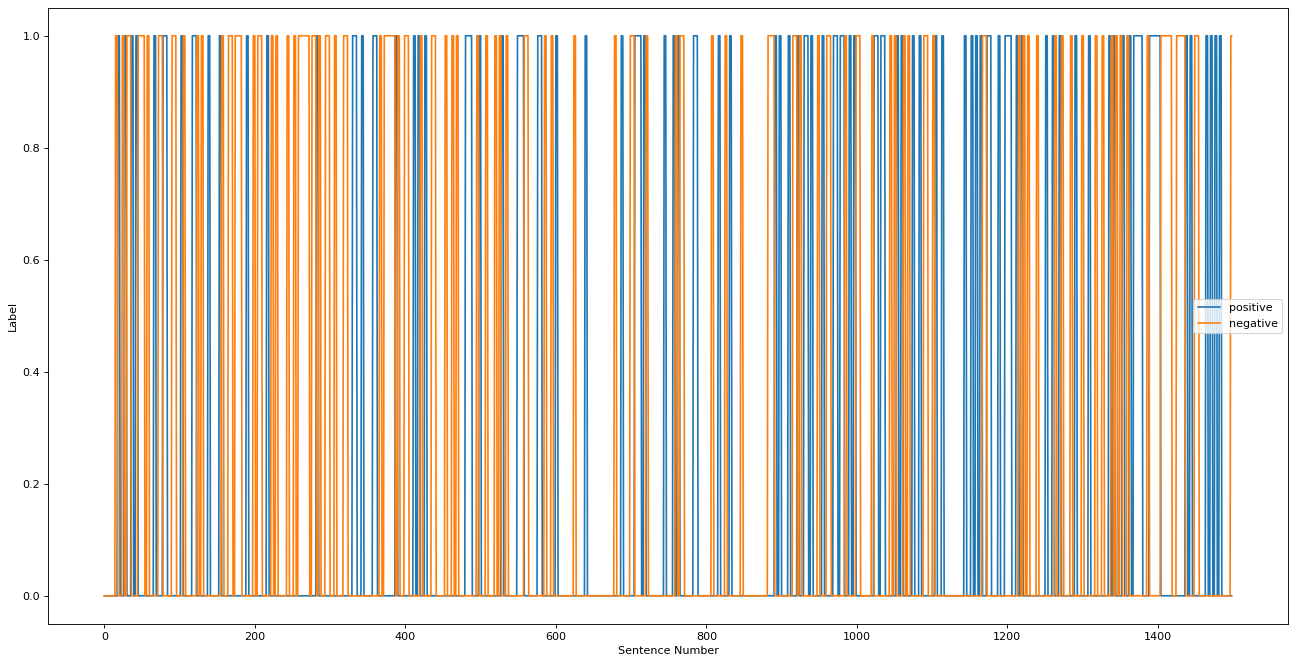

In [16]:
from matplotlib.pyplot import figure

figure(figsize=(20, 10), dpi=80)
plt.plot(sentiment_df['positive'], label='positive')
plt.plot(sentiment_df['negative'], label='negative')
#plt.plot(sentiment_df['neutral'], label='neutral')
plt.xlabel("Sentence Number")
plt.ylabel("Label")
plt.legend()

In [14]:
prob_cols = ['positive', 'negative', 'neutral']

THRESHOLD = 0.6

# Function to convert probabilities to 1 for the maximum probability and 0 for others
def convert_to_binary(row):
    if max(row[prob_cols]) < THRESHOLD:
        row[prob_cols] = False
        return row
    max_col = row[prob_cols].idxmax()
    row[prob_cols] = False
    row[max_col] = True
    return row

def should_be_kept(row):
    if max(row[prob_cols]) == 0:
        return False
    return True

# Apply the function to each row
sentiment_df = sentiment_df.apply(convert_to_binary, axis=1)

In [15]:
# Apply voting filter
sentiment_df[prob_cols] = voting_filter(sentiment_df, prob_cols, 3)

In [51]:
sentiment_df = sentiment_df[sentiment_df.apply(should_be_kept, axis=1)]

In [308]:
num_pos = len(sentiment_df[sentiment_df["positive"] == 1])
num_neg = len(sentiment_df[sentiment_df["negative"] == 1])
num_neut = len(sentiment_df[sentiment_df["neutral"] == 1])
print(num_pos, num_neg, num_neut)

202 247 678


In [309]:
sentiment_df["t1"] = sentiment_df["t1"].apply(lambda x: x/2).apply(np.ceil)
sentiment_df["t2"] = sentiment_df["t2"].apply(lambda x: x/2).apply(np.ceil)

In [278]:
remove_n = abs(num_neut - num_neg)
drop_indices = np.random.choice(sentiment_df[sentiment_df['neutral'] == 1].index, remove_n, replace=False)
sentiment_df = sentiment_df.drop(drop_indices)

# Match Labels with fMRI data

In [310]:
fmri_files = [os.path.join(roi_folder, file) for file in os.listdir(roi_folder)]
fmri_data = [np.load(file) for file in fmri_files]

In [311]:
roi_folder

'/media/moemen/Stuff/project/data/processed/sub-EN057/ROIs/left_amygdala'

In [312]:
for fmri in fmri_data:
    print(fmri.shape)

(5, 5, 5, 282)
(5, 5, 5, 298)
(5, 5, 5, 340)
(5, 5, 5, 303)
(5, 5, 5, 265)
(5, 5, 5, 343)
(5, 5, 5, 325)
(5, 5, 5, 292)
(5, 5, 5, 368)


In [326]:
num_TRs = 3
start_from = 1
cube_size = 5

X = np.empty(shape=(0,cube_size*cube_size*cube_size*num_TRs))
y = np.empty(shape=(0, 3))
for row in sentiment_df.iterrows():
    t2 = int(row[1]['t2'])
    section = int(row[1]['section'])
    fmri_file = fmri_data[section]
    fmri_duration = fmri_file.shape[-1]
    relevant_fmri_data = []
    not_enough = False
    for i in range(start_from, num_TRs+start_from):
        if t2+i >= fmri_duration:
            not_enough = True
            continue
        relevant_fmri_data.append(fmri_file[:,:,:, t2+i])
    if not_enough:
        print('skip')
        continue
    relevant_fmri_data = np.array(relevant_fmri_data)
    labels = np.array([row[1]['positive'], row[1]['negative'], row[1]['neutral']])
#    labels = np.array([row[1]['affect']])
#    mean_fmri = np.mean(relevant_fmri_data, axis=0).reshape(cube_size*cube_size*cube_size,)
    concat_fmri = relevant_fmri_data.reshape(cube_size*cube_size*cube_size*num_TRs,)
    X = np.vstack((X, concat_fmri))
    y = np.vstack((y, labels))

skip
skip
skip


In [327]:
print(X.shape, y.shape)

(1124, 375) (1124, 3)


In [334]:
y.shape

(1124, 3)

In [329]:
y = y.astype(int)

In [317]:
y = np.argmax(y, axis=1)
y

array([2, 2, 2, ..., 2, 2, 1])

In [330]:
X[:, 0].std()

318.42898336937145

In [331]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Define and Train the Model 

In [338]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

In [339]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [340]:
ros_train = RandomOverSampler(random_state=4) 
ros_test = RandomOverSampler(random_state=42)

X_train, y_train = ros_train.fit_resample(X_train, y_train)
X_test, y_test = ros_test.fit_resample(X_test, y_test)

In [323]:
unique_values, counts = np.unique(y_test, return_counts=True)

# Combine the unique values and their counts into a dictionary
value_counts = dict(zip(unique_values, counts))

# Print the result
print("Value Counts:")
print(value_counts)


Value Counts:
{0: 125, 1: 125, 2: 125}


In [324]:
classifier = OneVsOneClassifier(LinearSVC(dual='auto', random_state=42, penalty='l1', max_iter=2000))
classifier.fit(X_train, y_train)
print('train', classifier.score(X_train, y_train))
print('test', classi
ValueError: Using a target size (torch.Size([])) that is different to the input size (torch.Size([3])) is deprecated. Please ensure they have the same size.fier.score(X_test, y_test))

/home/moemen/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/moemen/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


train 0.4688445251058681
test 0.3973333333333333


/home/moemen/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [325]:
classifier = OneVsOneClassifier(LogisticRegression(random_state=42, penalty='l2', max_iter=2000))
classifier.fit(X_train, y_train);
print('train', classifier.score(X_train, y_train))
print('test', classifier.score(X_test, y_test))

train 0.45614035087719296
test 0.39466666666666667
